<a href="https://colab.research.google.com/github/joyceee916/ATMS597-Project-6-Group-C/blob/master/Project6_GroupC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules and data

In [0]:
%pylab inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn import datasets, linear_model
import seaborn as sns; sns.set()

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Set your data directory
YOUR_DIR = '/content/drive/My Drive/Colab Notebooks/ATMS 597/P06/Data/' # Cathy
#YOUR_DIR = '/content/drive/My Drive/ATMS 597/Project6/' # Joyce
#...

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# disastersum_df = pd.read_csv(YOUR_DIR + 'DisasterDeclarationsSummaries.csv')
# disastersum_df

In [0]:
claims_df = pd.read_csv(YOUR_DIR + 'openFEMA_claims20190831.csv', low_memory=False)
claims_df

FileNotFoundError: ignored

In [0]:
# Keep only potentially useful columns
clean_df = claims_df[['basefloodelevation', 'policycount', 'elevatedbuildingindicator', 
         'elevationdifference', 'floodzone', 'originalconstructiondate', 
         'originalnbdate', 'amountpaidonbuildingclaim', 'amountpaidoncontentsclaim', 
         'amountpaidonincreasedcostofcomplianceclaim', 'postfirmconstructionindicator', 
         'ratemethod', 'state', 'totalbuildinginsurancecoverage', 
         'totalcontentsinsurancecoverage', 'yearofloss', 'dateofloss']]

# Convert negative values for claims to their positive values (because a negative value means that the check issued to the policyholder wasn't cashed in, and needs to be reissued)
clean_df.amountpaidonbuildingclaim = clean_df.amountpaidonbuildingclaim.abs()
clean_df.amountpaidoncontentsclaim = clean_df.amountpaidoncontentsclaim.abs()
clean_df.amountpaidonincreasedcostofcomplianceclaim = clean_df.amountpaidonincreasedcostofcomplianceclaim.abs()

# Convert datetime instances to pd.datetime
clean_df['originalconstructiondate'] = pd.to_datetime(clean_df['originalconstructiondate'], errors='coerce')
clean_df['originalnbdate'] = pd.to_datetime(clean_df['originalnbdate'])
clean_df['dateofloss'] = pd.to_datetime(clean_df['dateofloss'])

# replace str indicators with numbers
clean_df.replace({'elevatedbuildingindicator': {'Y': 1, 'N': 0}}, inplace=True)
clean_df.replace({'postfirmconstructionindicator': {'Y': 1, 'N': 0}}, inplace=True)

# # Replace NaN values for claims with 0
# clean_df.amountpaidonbuildingclaim.fillna(0, inplace=True)
# clean_df.amountpaidoncontentsclaim.fillna(0, inplace=True)
# clean_df.amountpaidonincreasedcostofcomplianceclaim.fillna(0, inplace=True)

# Create a new column that is the sum of all of the amounts paid 
clean_df['totalamountpaid'] = clean_df['amountpaidonbuildingclaim'] + clean_df['amountpaidoncontentsclaim'] + clean_df['amountpaidonincreasedcostofcomplianceclaim']

# Delete intermediate columns 
clean_df.drop(columns=['amountpaidonbuildingclaim', 'amountpaidoncontentsclaim', 'amountpaidonincreasedcostofcomplianceclaim'], inplace=True)

# Replace elevation difference values that are 999.0 with NaN 
clean_df.replace({'elevationdifference': {999.0: np.nan}}, inplace=True)

clean_df

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

,basefloodelevation,policycount,elevatedbuildingindicator,elevationdifference,floodzone,originalconstructiondate,originalnbdate,postfirmconstructionindicator,ratemethod,state,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,dateofloss,totalamountpaid
0,NaN,1.0,0.0,NaN,X,1963-01-01,1997-01-11,0.0,7,CA,200000.0,50000.0,1998,1998-02-07,NaN
1,NaN,1.0,0.0,NaN,X,1967-07-01,1990-07-12,0.0,7,LA,100000.0,40000.0,2005,2005-08-29,NaN
2,NaN,1.0,0.0,NaN,X,1972-01-01,1997-07-24,0.0,1,FL,100000.0,50000.0,1998,1998-09-28,10533.21
3,NaN,1.0,0.0,NaN,X,1960-01-01,1993-10-01,0.0,7,SC,100000.0,25000.0,1994,1994-10-07,NaN
4,NaN,1.0,0.0,NaN,X,1988-01-01,1996-01-11,1.0,7,FL,100000.0,25000.0,1996,1996-03-11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432883,9.0,1.0,0.0,1.0,AHB,1985-01-01,2003-12-06,1.0,1,FL,131000.0,45000.0,2005,2005-08-26,6123.27
2432884,9.0,1.0,0.0,1.0,AHB,1990-01-01,2004-02-04,1.0,1,FL,153300.0,76700.0,2005,2005-08-25,5010.88
2432885,10.0,1.0,0.0,-1.0,AE,1959-01-01,2004-07-16,0.0,1,FL,245000.0,100000.0,2005,2005-06-20,8335.35
2432886,NaN,1.0,0.0,NaN,AE,1959-01-01,2004-07-16,0.0,1,FL,245000.0,100000.0,2005,2005-08-25,2396.44


# Linear Regression

In [0]:
### FROM M04 N03 ###
# !rm -rf course_repository
# !git clone -b data-science-fundamentals https://github.com/swnesbitt/ams-2020-ml-python-course/ course_repository

In [0]:
# import sys
# sys.path.append('/content/course_repository/Introduction_To_Machine_Learning/')
# sys.path.append('/content/course_repository/Introduction_To_Machine_Learning/Data_Science_Fundamentals/')
# sys.path.append('/content/course_repository')

In [0]:
# from os.path import dirname, abspath
# sys.path.insert(1, abspath('')+"/introduction_to_machine_learning")

# import copy
# import warnings
# import Data_Science_Fundamentals.utils as utils

In [0]:
### 
# linreg_model_object = utils.setup_linear_regression(
#     lambda1=0., lambda2=0.)

# _ = utils.train_linear_regression(
#     model_object=linreg_model_object,
#     training_predictor_table=claims_reduced[predictors], #training_predictor_table,
#     training_target_table=claims_reduced[predictand])

# training_predictions = linreg_model_object.predict(
#     training_predictor_table.values
# )
# mean_training_target_value = numpy.mean(
#     training_target_table[utils.TARGET_NAME].values
# )

# _ = utils.evaluate_regression(
#     target_values=training_target_table[utils.TARGET_NAME].values,
#     predicted_target_values=training_predictions,
#     mean_training_target_value=mean_training_target_value,
#     dataset_name='training')


# print(MINOR_SEPARATOR_STRING)

# validation_predictions = linreg_model_object.predict(
#     validation_predictor_table.values
# )

# _ = utils.evaluate_regression(
#     target_values=validation_target_table[utils.TARGET_NAME].values,
#     predicted_target_values=validation_predictions,
#     mean_training_target_value=mean_training_target_value,
#     dataset_name='validation')


In [0]:
predictors = ['basefloodelevation', 'policycount', 'elevatedbuildingindicator', 
         'elevationdifference', 'originalconstructiondate', 'floodzone', 
         'originalnbdate', 
         'postfirmconstructionindicator', 
         'ratemethod', 'totalbuildinginsurancecoverage', 'state', 
         'totalcontentsinsurancecoverage', 'yearofloss', 'dateofloss'] 
predictand = ['totalamountpaid']

claims_reduced = clean_df[predictors + predictand].dropna()
claims_reduced

,basefloodelevation,policycount,elevatedbuildingindicator,elevationdifference,originalconstructiondate,floodzone,originalnbdate,postfirmconstructionindicator,ratemethod,totalbuildinginsurancecoverage,state,totalcontentsinsurancecoverage,yearofloss,dateofloss,totalamountpaid
21,16.0,1.0,1.0,-16.0,1962-01-01,AE,1995-09-02,0.0,1,185000.0,SC,40000.0,1999,1999-06-15,2444.33
22,8.0,1.0,0.0,1.0,2000-12-01,AE,2001-06-13,1.0,1,250000.0,FL,82700.0,2004,2004-09-16,175941.92
36,9.0,1.0,0.0,1.0,1932-01-01,AE,1990-07-07,0.0,1,214100.0,VA,25500.0,2009,2009-11-14,4368.69
37,13.0,1.0,0.0,5.0,1926-01-01,AE,1997-06-16,0.0,1,250000.0,MS,100000.0,2005,2005-08-29,350000.00
40,9.0,1.0,0.0,4.0,1978-02-01,AE,1987-12-29,1.0,1,250000.0,FL,25000.0,2004,2004-09-15,35521.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432881,8.0,1.0,0.0,3.0,1983-01-01,AHB,2003-08-26,1.0,1,160700.0,FL,76700.0,2005,2005-08-26,10716.61
2432882,8.0,1.0,0.0,1.0,1983-01-01,AHB,2003-09-25,1.0,1,77000.0,FL,36800.0,2005,2005-08-26,948.96
2432883,9.0,1.0,0.0,1.0,1985-01-01,AHB,2003-12-06,1.0,1,131000.0,FL,45000.0,2005,2005-08-26,6123.27
2432884,9.0,1.0,0.0,1.0,1990-01-01,AHB,2004-02-04,1.0,1,153300.0,FL,76700.0,2005,2005-08-25,5010.88


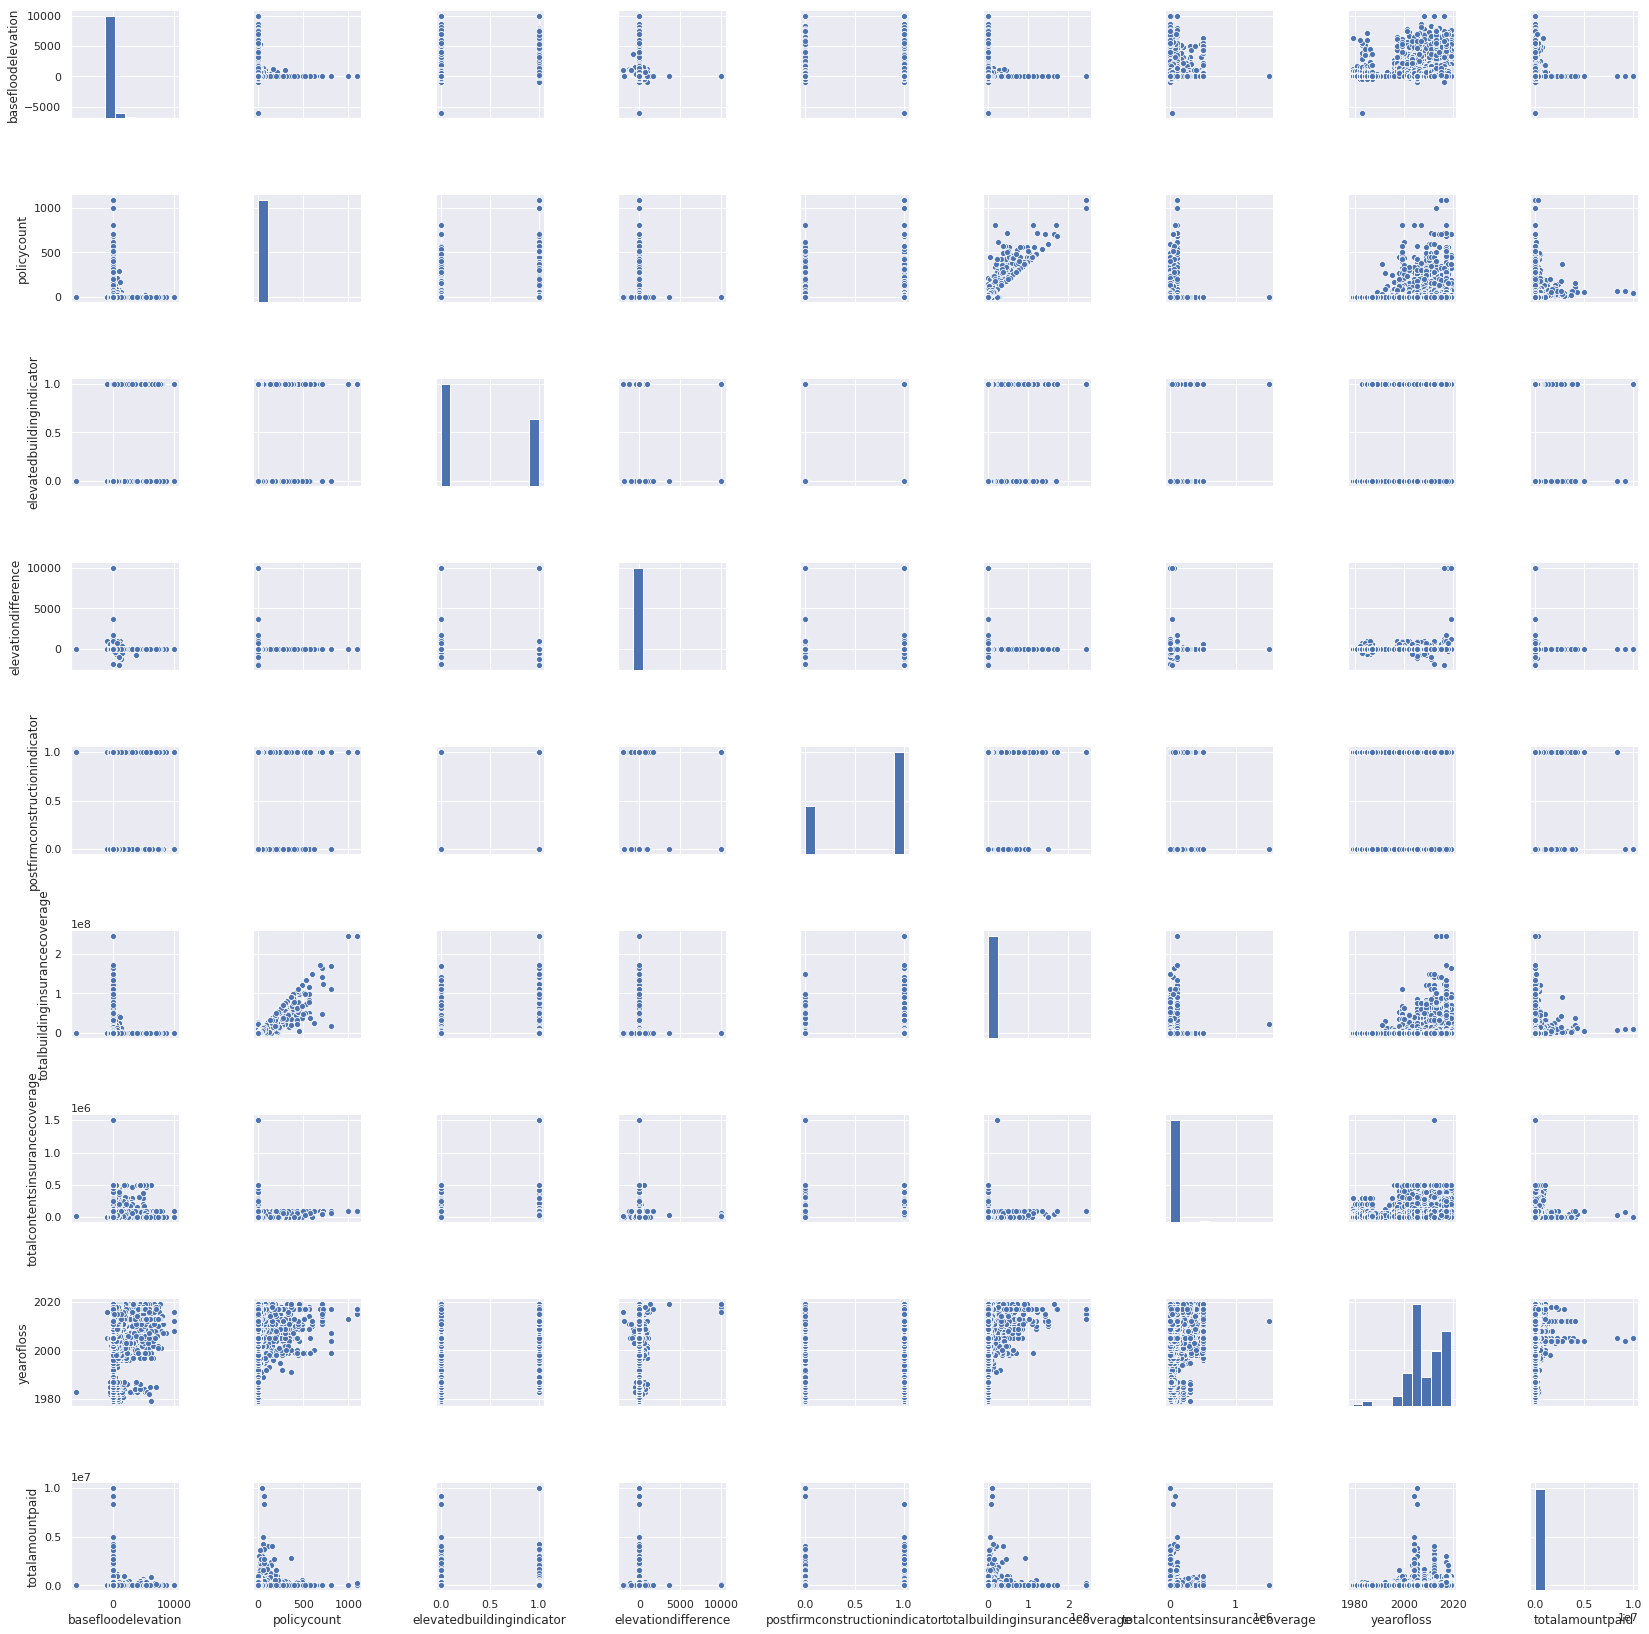

In [0]:
sns.pairplot(claims_reduced);

In [0]:
# One-hot encoding, dropping one column in each feature to avoid OHE trap
dummies_ratemethod = pd.get_dummies(claims_reduced['ratemethod'], prefix='ratemethod').iloc[:,1:]
dummies_floodzone = pd.get_dummies(claims_reduced['floodzone'], prefix = 'floodzone').iloc[:,1:]
dummies_state = pd.get_dummies(claims_reduced['state'], prefix = 'state').iloc[:,1:]

claims_encoded = pd.concat([claims_reduced.drop(['ratemethod', 'floodzone', 'state'], axis = 1), dummies_ratemethod, dummies_floodzone, dummies_state], axis = 1)
claims_encoded

,basefloodelevation,policycount,elevatedbuildingindicator,elevationdifference,originalconstructiondate,originalnbdate,postfirmconstructionindicator,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,dateofloss,totalamountpaid,ratemethod_2,ratemethod_3,ratemethod_4,ratemethod_5,ratemethod_6,ratemethod_8,ratemethod_A,ratemethod_B,ratemethod_E,ratemethod_F,ratemethod_P,ratemethod_Q,ratemethod_S,ratemethod_W,floodzone_A00,floodzone_A01,floodzone_A02,floodzone_A03,floodzone_A04,floodzone_A05,floodzone_A06,floodzone_A07,floodzone_A08,floodzone_A09,floodzone_A0B,floodzone_A10,floodzone_A11,floodzone_A12,...,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY
21,16.0,1.0,1.0,-16.0,1962-01-01,1995-09-02,0.0,185000.0,40000.0,1999,1999-06-15,2444.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
22,8.0,1.0,0.0,1.0,2000-12-01,2001-06-13,1.0,250000.0,82700.0,2004,2004-09-16,175941.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36,9.0,1.0,0.0,1.0,1932-01-01,1990-07-07,0.0,214100.0,25500.0,2009,2009-11-14,4368.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
37,13.0,1.0,0.0,5.0,1926-01-01,1997-06-16,0.0,250000.0,100000.0,2005,2005-08-29,350000.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,9.0,1.0,0.0,4.0,1978-02-01,1987-12-29,1.0,250000.0,25000.0,2004,2004-09-15,35521.95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432881,8.0,1.0,0.0,3.0,1983-01-01,2003-08-26,1.0,160700.0,76700.0,2005,2005-08-26,10716.61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2432882,8.0,1.0,0.0,1.0,1983-01-01,2003-09-25,1.0,77000.0,36800.0,2005,2005-08-26,948.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2432883,9.0,1.0,0.0,1.0,1985-01-01,2003-12-06,1.0,131000.0,45000.0,2005,2005-08-26,6123.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2432884,9.0,1.0,0.0,1.0,1990-01-01,2004-02-04,1.0,153300.0,76700.0,2005,2005-08-25,5010.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# inspect if ratemethod category was properly inserted
filter_col = [col for col in claims_encoded if col.startswith('ratemethod')]
claims_encoded[filter_col]

,ratemethod_2,ratemethod_3,ratemethod_4,ratemethod_5,ratemethod_6,ratemethod_8,ratemethod_A,ratemethod_B,ratemethod_E,ratemethod_F,ratemethod_P,ratemethod_Q,ratemethod_S,ratemethod_W
21,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432881,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2432882,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2432883,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2432884,0,0,0,0,0,0,0,0,0,0,0,0,0,0


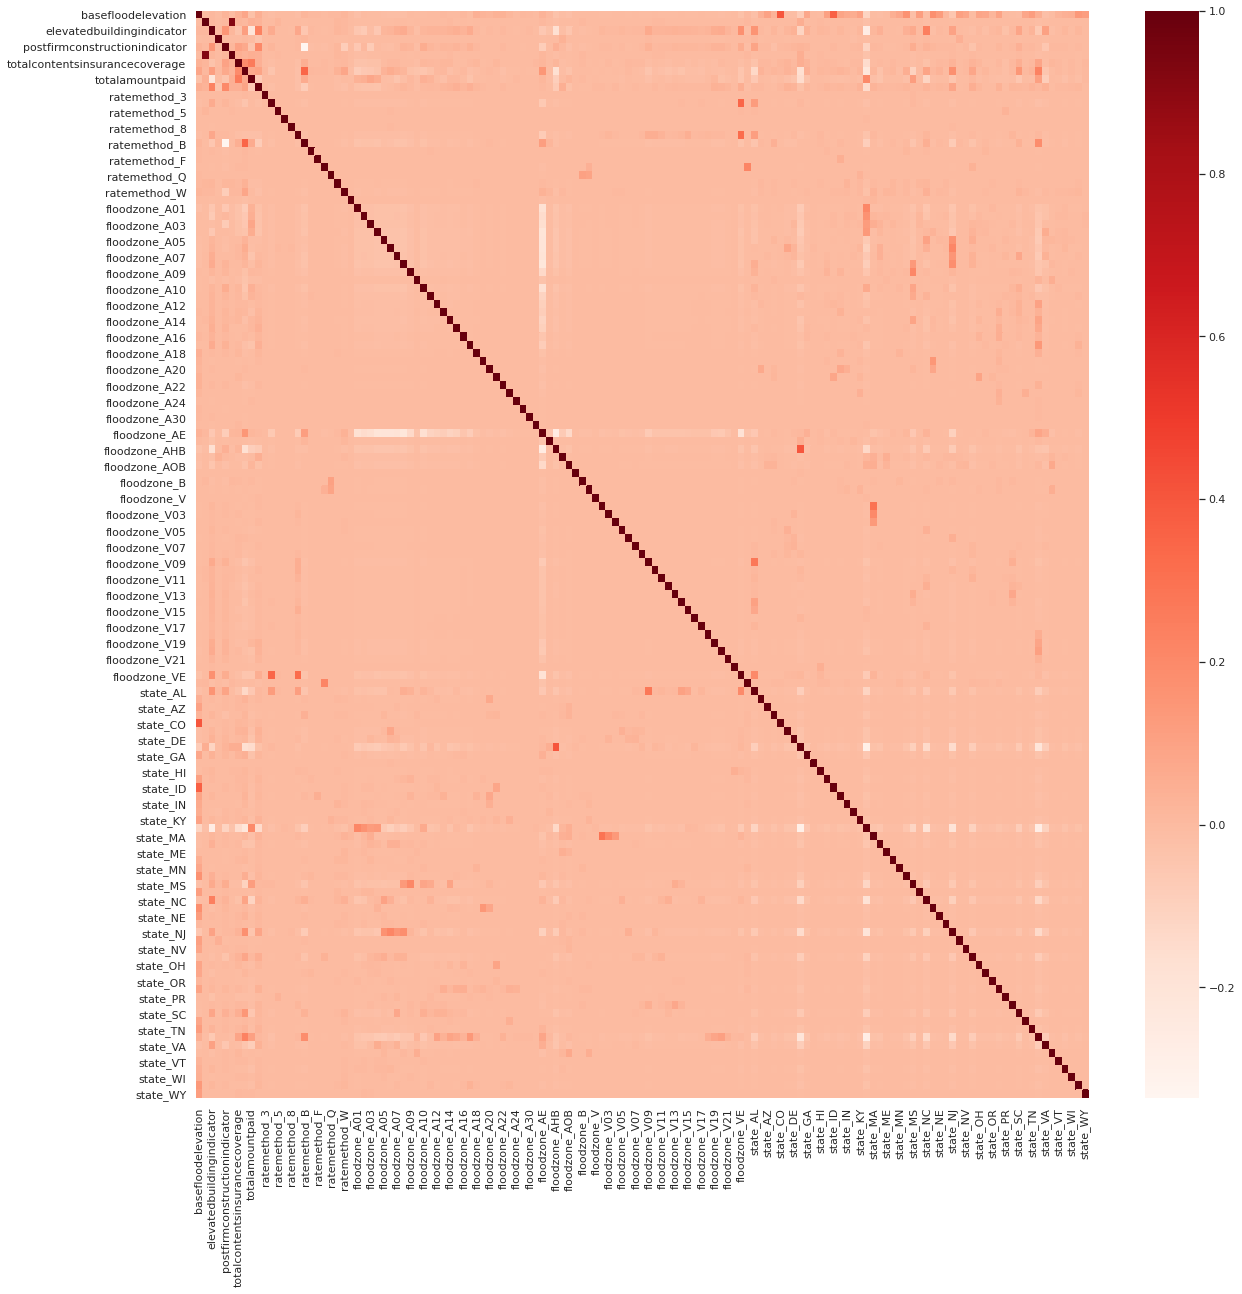

In [0]:
# Visualize the correlations relevance
cor = claims_encoded.corr()
plt.figure(figsize = (20,20))
sns.heatmap(cor, cmap = plt.cm.Reds);

In [0]:
# find most relevant features:
cor_target = abs(cor['totalamountpaid'])
 
relevant_features = cor_target[cor_target>0.10]
relevant_features

elevatedbuildingindicator         0.208806
totalcontentsinsurancecoverage    0.263428
totalamountpaid                   1.000000
state_FL                          0.153112
state_LA                          0.198314
state_MS                          0.120368
state_NC                          0.111821
state_TX                          0.109101
Name: totalamountpaid, dtype: float64

In [0]:
# Using everything in the encoded df -
features = claims_encoded.columns.drop(['originalnbdate', 'originalconstructiondate', 'dateofloss'] + predictand)
X = claims_encoded[features]
y = claims_encoded[predictand].squeeze()

# Using features with coefs > 0.1 -
# features = relevant_features.keys().drop(predictand)
# X = claims_encoded[features]
# y = claims_encoded[predictand].squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()#fit_intercept=False)
model.fit(X, y)

print("Model slope:    ", model.coef_)
print("Model intercept:", model.intercept_)

# predicted y for X_train and X_test
y_model = model.predict(X_train)
y_pred = model.predict(X_test)

rmse_train = sqrt(mean_squared_error(y_train, y_model))
rmse_test = sqrt(mean_squared_error(y_test, y_pred))
print("\nRMSE for training: ", rmse_train, "\nRMSE for testing: ", rmse_test)

# Using everything in the encoded df -
# RMSE for training:  79252.08063820064 
# RMSE for testing:  80949.53152910892

# Using features with coefs > 0.1 -
# RMSE for training:  80643.97880410933 
# RMSE for testing:  82311.08246769616

Model slope:     [-7.52096612e+00  3.07495169e+02 -2.74024839e+04 -6.54611766e+00
 -3.79165185e+03  8.82596119e-04  5.17089674e-01  1.06100388e+03
 -4.36090154e+03 -1.32915751e+05  2.82597747e+04 -4.23071511e+04
  2.71742563e+04  5.30234905e+04 -1.84151005e+02  8.78563016e+03
  4.79151617e+04  4.11790972e+03  1.17236713e+04 -4.00177839e+04
 -2.05547903e+04  4.09164150e+03 -2.86625534e+04  1.50022768e+04
  2.99405906e+04  6.55587539e+04  3.70421888e+04  2.60203679e+04
  2.37709846e+04  1.07015348e+04  7.91399487e+03  1.03654734e+04
 -1.65744929e+04  2.92794874e+04  4.25932345e+04  6.19858071e+03
 -1.63578480e+04  5.31708461e+03  2.65220634e+04  9.99103857e+03
 -3.27003846e+04 -3.07333293e+04  2.75769413e+03  1.19406449e+04
 -2.25646470e+04 -1.43033956e+04 -7.78210031e+03  6.89566855e+04
 -2.33389831e+04  1.00177989e+04 -5.91025508e+04  1.52104579e+04
  4.15427860e+02 -6.08061126e+03  2.09388854e+04  2.25507967e+04
 -2.93028035e+04  2.52951051e+04  5.82491356e+03 -1.90917060e+04
  4.5005

# Random Forest

In [0]:
claims_reduced[predictand].describe()

,totalamountpaid
count,2.278040e+05
mean,6.242293e+04
std,9.532139e+04
min,0.000000e+00
25%,5.028807e+03
50%,2.126876e+04
75%,9.327605e+04
max,9.169507e+06


In [0]:
# Using everything in the encoded df -
features = claims_encoded.columns.drop( ['originalnbdate', 'originalconstructiondate', 'dateofloss'] + predictand)

import copy
claims_delta = copy.deepcopy(claims_encoded[features])
claims_delta['originalnbdate'] = (claims_encoded.originalnbdate - datetime64('1980-01-01')).astype('timedelta64[D]')
claims_delta['originalconstructiondate'] = (claims_encoded.originalconstructiondate - datetime64('1900-01-01')).astype('timedelta64[D]')
claims_delta['dateofloss'] = (claims_encoded.dateofloss - datetime64('1980-01-01')).astype('timedelta64[D]')

X = claims_delta
# X = claims_encoded[features]
y = claims_encoded[predictand].squeeze()

# X = claims_reduced[predictors]
# y = claims_reduced[predictand].squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

y_scaler = preprocessing.StandardScaler().fit(y_train.values.reshape(-1,1))
y_train_norm = y_scaler.transform(y_train.values.reshape(-1,1)).squeeze()
y_test_norm = y_scaler.transform(y_test.values.reshape(-1,1)).squeeze()

# # Random Forrest - without normalization
# model = RandomForestRegressor(n_estimators = 250, max_features = 2)#n_estimators = 1500, max_features = 1)
# model.fit(X_train_norm, y_train)

# # predicted y for X_train and X_test
# y_model = model.predict(X_train_norm)
# y_pred = model.predict(X_test_norm)

# rmse_train = sqrt(mean_squared_error(y_train, y_model))
# rmse_test = sqrt(mean_squared_error(y_test, y_pred))
# print(rmse_train, rmse_test)

# Random Forrest
model = RandomForestRegressor(n_estimators = 250, max_features = 2)#n_estimators = 1500, max_features = 1)
model.fit(X_train_norm, y_train_norm)

# predicted y for X_train and X_test
y_model = model.predict(X_train_norm)
y_pred = model.predict(X_test_norm)

rmse_train = sqrt(mean_squared_error(y_train_norm, y_model))
rmse_test = sqrt(mean_squared_error(y_test_norm, y_pred))
print(rmse_train, rmse_test)

# Using claims_reduced -
# 35466.940443221916 84803.02017366493

# Using claims_encoded - 
# 31961.716608561506 63264.482823878694

# Using claims_delta - with date predictors
# 25784.438317369353 60502.200272203576

# Using claims_delta - and input all with Standardization
# 25616.592958045352 60356.94213564712

# Using claims_delta - features and labels all Standardized.
# 0.26273981475067437 0.6213297775454701

0.2584810300695104 0.6199865708844057


In [0]:
X_train.shape, X_test.shape

((159462, 134), (68342, 134))

In [0]:
plt.figure(figsize = (20,4))
plt.plot(np.arange(len(y_train))[::500], y_train[::500], label='Train')
plt.scatter(np.arange(len(y_model))[::500], y_model[::500], label='Fit')
plt.legend()
plt.title('Training set, RMSE: {0:.1e}'.format(rmse_train))
plt.show()

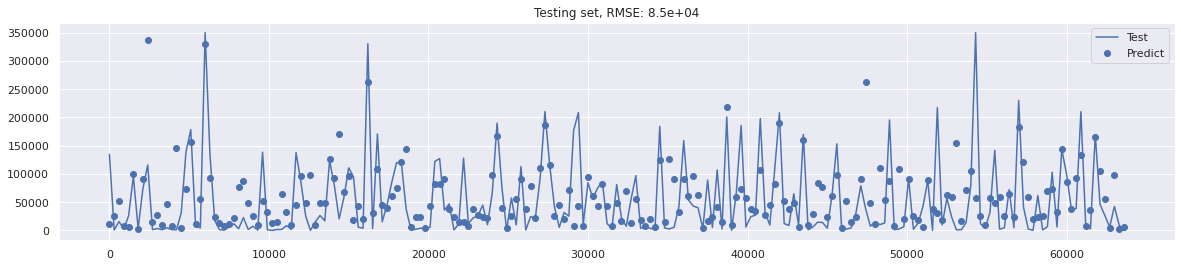

In [0]:
# before normalization
plt.figure(figsize = (20,4))
plt.plot(np.arange(len(y_test))[::300], y_test[::300], label='Test')
plt.scatter(np.arange(len(y_pred))[::300], y_pred[::300], label='Predict')
plt.legend()
plt.title('Testing set, RMSE: {0:.1e}'.format(rmse_test))
plt.show()

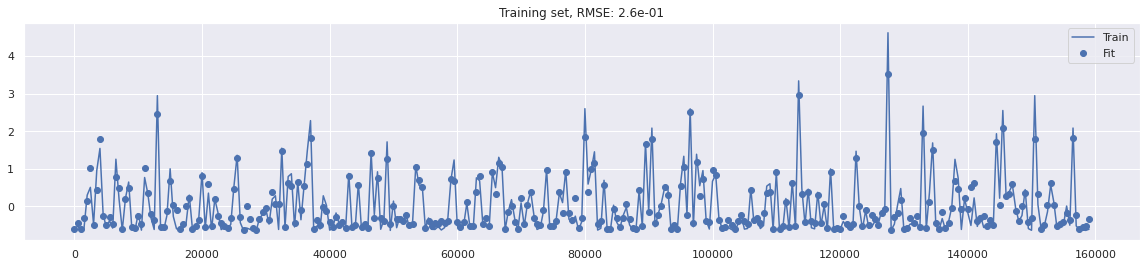

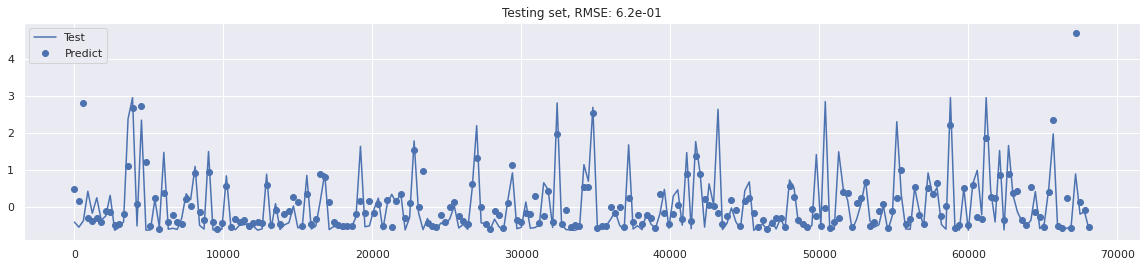

In [0]:
# after normalization
plt.figure(figsize = (20,4))
plt.plot(np.arange(len(y_train_norm))[::500], y_train_norm[::500], label='Train')
plt.scatter(np.arange(len(y_model))[::500], y_model[::500], label='Fit')
plt.legend()
plt.title('Training set, RMSE: {0:.1e}'.format(rmse_train))
plt.show()

plt.figure(figsize = (20,4))
plt.plot(np.arange(len(y_test_norm))[::300], y_test_norm[::300], label='Test')
plt.scatter(np.arange(len(y_pred))[::300], y_pred[::300], label='Predict')
plt.legend()
plt.title('Testing set, RMSE: {0:.1e}'.format(rmse_test))
plt.show()

# Neural Network

In [0]:
features = ['basefloodelevation', 'policycount', 
            'totalbuildinginsurancecoverage', 'totalcontentsinsurancecoverage', 
            'postfirmconstructionindicator', 'yearofloss', 'ratemethod'] 
            #'state']
target = ['totalamountpaid']    

claims_reduced = clean_df[features + target].dropna()
claims_reduced

,basefloodelevation,policycount,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,postfirmconstructionindicator,yearofloss,ratemethod,totalamountpaid
21,16.0,1.0,185000.0,40000.0,0.0,1999,1,2444.33
22,8.0,1.0,250000.0,82700.0,1.0,2004,1,175941.92
36,9.0,1.0,214100.0,25500.0,0.0,2009,1,4368.69
37,13.0,1.0,250000.0,100000.0,0.0,2005,1,350000.00
40,9.0,1.0,250000.0,25000.0,1.0,2004,1,35521.95
...,...,...,...,...,...,...,...,...
2432881,8.0,1.0,160700.0,76700.0,1.0,2005,1,10716.61
2432882,8.0,1.0,77000.0,36800.0,1.0,2005,1,948.96
2432883,9.0,1.0,131000.0,45000.0,1.0,2005,1,6123.27
2432884,9.0,1.0,153300.0,76700.0,1.0,2005,1,5010.88


In [0]:
claims_reduced.replace({'ratemethod': {'B': 10, 'A': 11, 'Q':12, 'P':13, 'W':14, 'S':15, 'F':16, 'E': 17, 9.0:9, 8.0:8, 5.0:5, 6.0:6, 
                           'G':18, 'T':19, '7':7, '1':1, '2':2, '4':4, '3':3, '8':8, '6':6, '9':9, '5':5}}, inplace=True)

In [0]:
# One-hot encoding
# dummies_ratemethod = pd.get_dummies(claims_reduced['ratemethod'], prefix='ratemethod').iloc[:,1:]
# #dummies_state = pd.get_dummies(claims_reduced['state'], prefix = 'state').iloc[:,1:]

# claims_encoded = pd.concat([claims_reduced.drop(['ratemethod'], axis = 1), dummies_ratemethod, dummies_floodzone, dummies_state], axis = 1)
# claims_encoded

,basefloodelevation,policycount,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,postfirmconstructionindicator,yearofloss,totalamountpaid,ratemethod_2,ratemethod_3,ratemethod_4,ratemethod_5,ratemethod_6,ratemethod_7,ratemethod_8,ratemethod_A,ratemethod_B,ratemethod_E,ratemethod_F,ratemethod_P,ratemethod_Q,ratemethod_S,ratemethod_W,floodzone_A00,floodzone_A01,floodzone_A02,floodzone_A03,floodzone_A04,floodzone_A05,floodzone_A06,floodzone_A07,floodzone_A08,floodzone_A09,floodzone_A0B,floodzone_A10,floodzone_A11,floodzone_A12,floodzone_A13,floodzone_A14,floodzone_A15,floodzone_A16,...,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY
21,16.0,1.0,185000.0,40000.0,0.0,1999,2444.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,8.0,1.0,250000.0,82700.0,1.0,2004,175941.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,9.0,1.0,214100.0,25500.0,0.0,2009,4368.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
37,13.0,1.0,250000.0,100000.0,0.0,2005,350000.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,9.0,1.0,250000.0,25000.0,1.0,2004,35521.95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432881,8.0,1.0,160700.0,76700.0,1.0,2005,10716.61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2432882,8.0,1.0,77000.0,36800.0,1.0,2005,948.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2432883,9.0,1.0,131000.0,45000.0,1.0,2005,6123.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2432884,9.0,1.0,153300.0,76700.0,1.0,2005,5010.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [0]:
#x_train, x_test, y_train, y_test = train_test_split(claims_encoded.drop(target, axis = 1), claims_encoded[target], test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(claims_reduced[features], claims_reduced[target], test_size=0.2)

# x_train = tf.keras.utils.normalize(x_train, axis=1)
# x_test = tf.keras.utils.normalize(x_test, axis=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(182616, 7)
(182616, 1)
(45655, 7)
(45655, 1)


In [0]:
model = Sequential()

n_cols = x_train.shape[1]

model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='SGD', loss='mean_squared_error') #metrics=['mae', 'mse'])

In [0]:
early_stopping_monitor = EarlyStopping(patience=3)

model.fit(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping_monitor])

# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch

# rmse_train_NN = np.sqrt(float(hist['val_mse'].tail(1)))
# print(rmse_train_NN)

Train on 146092 samples, validate on 36524 samples
Epoch 1/10
 49376/146092 [=========>....................] - ETA: 6s - loss: nan

KeyboardInterrupt: ignored

In [0]:
import math 
from math import sqrt
y_model = model.predict(x_train)
y_predict = model.predict(x_test)

rmse_train = sqrt(mean_squared_error(y_train, y_model))
rmse_test = sqrt(mean_squared_error(y_test, y_predict))
print(rmse_train, rmse_test)

94145.45558943538 100206.60084721466


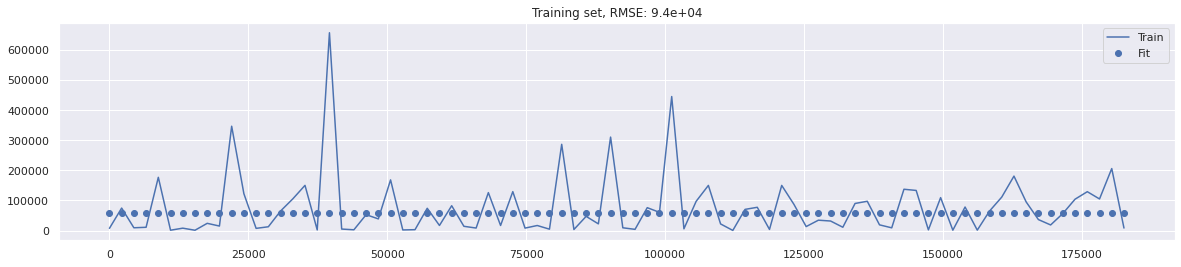

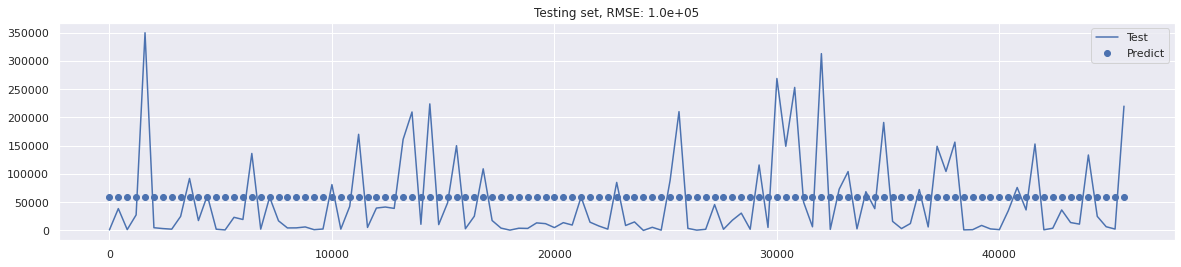

In [0]:
plt.figure(figsize = (20,4))
plt.plot(np.arange(len(y_train))[::2200], y_train[::2200], label='Train')
plt.scatter(np.arange(len(y_model))[::2200], y_model[::2200], label='Fit')
plt.legend()
plt.title('Training set, RMSE: {0:.1e}'.format(rmse_train))
plt.show()

plt.figure(figsize = (20,4))
plt.plot(np.arange(len(y_test))[::400], y_test[::400], label='Test')
plt.scatter(np.arange(len(y_predict))[::400], y_predict[::400], label='Predict')
plt.legend()
plt.title('Testing set, RMSE: {0:.1e}'.format(rmse_test))
plt.show()

In [0]:
### From Bowen ###
# with standardization
model = Sequential()

n_cols = X_train_norm.shape[1]

model.add(Dense(10, activation='relu', input_shape=(n_cols,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', #tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
              loss='mean_squared_error',
              metrics=['mae', 'mse'])

In [0]:
early_stopping_monitor = EarlyStopping(patience=3)

history = model.fit(X_train_norm, y_train_norm, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

rmse_train_NN = np.sqrt(float(hist['val_mse'].tail(1)))
print(rmse_train_NN)
# 0.7399104473982425

Train on 127569 samples, validate on 31893 samples
Epoch 1/100
127569/127569 [==============================] - 16s 126us/step - loss: 0.8277 - mae: 0.5176 - mse: 0.8277 - val_loss: 0.6416 - val_mae: 0.4861 - val_mse: 0.6416
Epoch 2/100
127569/127569 [==============================] - 16s 126us/step - loss: 0.7350 - mae: 0.4722 - mse: 0.7350 - val_loss: 0.6021 - val_mae: 0.4709 - val_mse: 0.6021
Epoch 3/100
127569/127569 [==============================] - 16s 126us/step - loss: 0.7137 - mae: 0.4622 - mse: 0.7137 - val_loss: 0.6285 - val_mae: 0.4667 - val_mse: 0.6285
Epoch 4/100
127569/127569 [==============================] - 16s 125us/step - loss: 0.6884 - mae: 0.4553 - mse: 0.6884 - val_loss: 0.6232 - val_mae: 0.4623 - val_mse: 0.6232
Epoch 5/100
127569/127569 [==============================] - 17s 135us/step - loss: 0.6794 - mae: 0.4524 - mse: 0.6794 - val_loss: 0.7084 - val_mae: 0.4566 - val_mse: 0.7084
0.8416674308647488
